In [21]:
import torch
import torchvision
import matplotlib.pyplot as plt

In [23]:
dataset = torchvision.datasets.MNIST(root='./data', download=True)

In [3]:
dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train

In [4]:
def cmp(s, dt, t):
  ex = torch.all(dt == t.grad).item()
  app = torch.allclose(dt, t.grad)
  maxdiff = (dt - t.grad).abs().max().item()
  print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [5]:
X = dataset.data
Y = dataset.targets

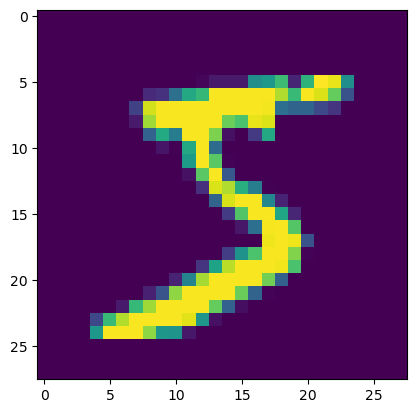

In [6]:
plt.imshow(X[0])

In [7]:
train_size = 50000
X_train = X[:train_size] /255
Y_train = Y[:train_size]
Y_train = Y[:train_size].unsqueeze(1)

X_test = X[train_size:] /255
Y_test = Y[train_size:]
Y_test = Y[train_size:].unsqueeze(1)

In [8]:
torch.manual_seed(42)

n_classes = 10
alpha = 0.1
losses = []

input_size = 28 * 28
W = torch.randn(input_size, n_classes, requires_grad=True) * 0.05
b = torch.randn(1, n_classes, requires_grad=True)

## Understanding softmax

In [9]:
import numpy as np
def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=0)

In [10]:
sx = np.array([2.0, 1.0, 0.1])
outputs = softmax(sx)
print('Softmax numpy:', outputs)

Softmax numpy: [0.65900114 0.24243297 0.09856589]


In [11]:
sx = torch.tensor([2.0, 1.0, 0.1])
outputs = torch.softmax(sx, dim=0)
outputs

tensor([0.6590, 0.2424, 0.0986])

## Understanding Crossentropy

In [12]:
def cross_entropy(actual, predicted):
    return -np.sum(actual * np.log(predicted))

In [13]:
cy = np.array([1, 0, 0])

In [14]:
cy_pred_good = np.array([0.7, 0.2, 0.1])
cy_pred_bad = np.array([0.1, 0.3, 0.6])
l1 = cross_entropy(cy, cy_pred_good)
l2 = cross_entropy(cy, cy_pred_bad)
l1, l2

(0.35667494393873245, 2.3025850929940455)

In [15]:
W.shape, b.shape, X_train.shape, Y_train.shape

(torch.Size([784, 10]),
 torch.Size([1, 10]),
 torch.Size([50000, 28, 28]),
 torch.Size([50000, 1]))

In [16]:
for i in range(1000):
    Z = X_train.view(-1, input_size) @ W + b
    zmax = Z.max(dim=1, keepdim=True).values
    znorm = Z - zmax
    
    zexp = znorm.exp() 
    zexp_sum = zexp.sum(dim=1, keepdim=True)
    zexp_sum_inv = zexp_sum ** (-1)
    probs = zexp * zexp_sum_inv
    log_probs = probs.log()
    L = -log_probs[torch.arange(len(Y_train)), Y_train.squeeze()].mean()
    losses.append(L.item())
    
    dL_dL = torch.ones_like(L)
    dL_dlogprobs = torch.zeros_like(log_probs)
    dL_dlogprobs[torch.arange(len(Y_train)), Y_train.squeeze()] = -dL_dL / len(Y_train)
    dL_dprobs = dL_dlogprobs * 1 / probs
    
    dL_dzexp = dL_dprobs * zexp_sum_inv
    dL_dzexp_sum_inv = (dL_dprobs * zexp).sum(1, keepdim=True)
    dL_dzexp_sum = -1 * dL_dzexp_sum_inv * zexp_sum**(-2)
    dL_dzexp += dL_dzexp_sum
    dL_dznorm = dL_dzexp * zexp.clone()
    
    dL_dzmax = -dL_dznorm.sum(1, keepdim=True)
    dL_dZ = dL_dznorm
    dL_dZ += torch.nn.functional.one_hot(Z.max(dim=1).indices, n_classes) * dL_dzmax
    
    dL_dW = X_train.view(-1, input_size).T @ dL_dZ
    dL_db = dL_dZ.sum(0, keepdim=True)
    
    for i in [Z, zexp, zexp_sum, zexp_sum_inv, znorm, zmax, probs, log_probs, W, b, L]:
        i.retain_grad()
    with torch.no_grad():
        W -= alpha * dL_dW
        b -= alpha * dL_db
    if i == 0 or (i % 100 == 0):
        print(f"epoch {i} loss: {L.item()}")

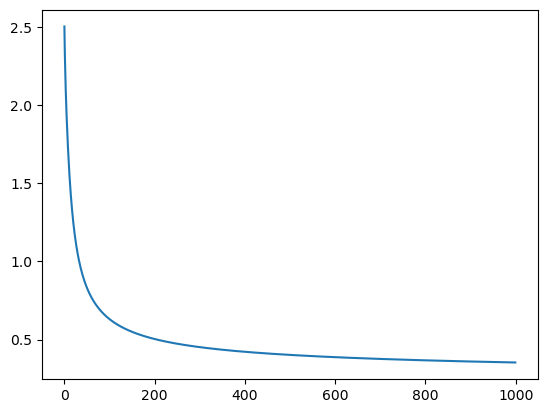

In [19]:
plt.plot(losses)

In [20]:
Z1 = X_test.view(-1, input_size) @ W + b
preds = torch.max(Z1, dim=1).indices
preds[:5], Y_test[:5].squeeze()


accuracy = (preds == Y_test.squeeze()).float().mean().item() * 100

print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 91.12%
